# Generating surface plots

_Written by Lori Garzio, March 10, 2025_

This tutorial outlines methods for generating pcolormesh surface maps of variables grabbed from the Rutgers University Weather Research and Forecasting Model (RU-WRF 4.1) from the [RUWRF THREDDs server](http://tds.marine.rutgers.edu/thredds/cool/ruwrf/catalog.html) to compare to the analyses described in Golbazi et al 2022 [DOI 10.1088/1748-9326/ac6e49](https://iopscience.iop.org/article/10.1088/1748-9326/ac6e49/meta).

Using the [wrf_data_wrangler_grid.py](https://github.com/rucool/wind-science/blob/master/rmi-ocean-mixing/wrf_data_wrangler_grid.py) script, we grabbed model output from the summer of 2022 (June - August) for the control model version [1km_ctrl](https://tds.marine.rutgers.edu/thredds/catalog/cool/ruwrf/wrf_4_1_1km_ctrl_processed/catalog.html), a 1km model domain without simulated turbines, as well as data from the wind farm model version [1km\_wf2km\_nyb](https://tds.marine.rutgers.edu/thredds/catalog/cool/ruwrf/case_studies/wrf_4_1_1km_wf2km_upwellingctrl_processed/catalog.html), a 1km model domain with simulated 15 MW turbines spaced 2km apart and filling all wind energy lease areas in the New York Bight as of early 2023. Monthly files were generated for the following variables and heights (if applicable):

	- variables: T2, TEMP, U, V, U10, V10, UST, Q2, TKE_PBL, HFX, TSK
	- heights: surface, 120m, 160m, 200m, 300m

After grabbing all of the model output, we generated summer 2022 averages using [data_averages.py](https://github.com/rucool/wind-science/blob/master/rmi-ocean-mixing/data_averages.py). Splitting the process into these two steps was necessary because of the length of time and computer resources it takes to grab this large volume of model output. The resulting files containing the summer 2022 averages for each variable can be downloaded [here](https://marine.rutgers.edu/~lgarzio/rmi_ocean_mixing/) if you want to skip the data wrangling and averaging process.

In [127]:
# import required packages
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import cmocean as cmo
from math import ceil
import cool_maps.plot as cplt
plt.rcParams.update({'font.size': 12})  # all font sizes are 12 unless otherwise specified

First, specify the locations of the NetCDF files containing the model output (control and turbines) you want to plot, as well as a location to save all of the images.

In [128]:
file_dir = '/Users/garzio/Documents/rucool/rmi-ocean-mixing/files/1km_wf2km_nyb'
file_dir_control = '/Users/garzio/Documents/rucool/rmi-ocean-mixing/files/1km_ctrl/'
save_dir = '/Users/garzio/Documents/rucool/rmi-ocean-mixing/plots'

Then, define some other parameters, such as the geographical extent for plotting the surface map, as well as the variable and height you want to plot. We'll start with plotting wind speed at at height of 160m (which is our theoretical 15MW turbine's hub height). The variable name from the filename is ws, this will be used for a number of different things including finding the correct files, plotting configurations, and naming save file names. A reminder that you can either generate the files yourself or download from [here](https://marine.rutgers.edu/~lgarzio/rmi_ocean_mixing/)). The full list of the variable names that you can plot are:
- HFX: upward heat flux at the surface
- Q2: water vapor mixing ratio at the surface
- T2: air temperature at the surface
- TEMP: air temperature at heights 120m, 160m, 200m, 300m
- TKE_PBL: turbulent kinetic energy at heights 120m, 160m, 200m, 300m
- TSK: surface skin temperature
- UST: friction velocity at the surface
- ws10: wind speed at 10m height
- ws: wind speed at heights 120m, 160m, 200m, 300m

In [129]:
extent = [-75.1, -72.2, 38.1, 40.5]  # [lon_min, lon_max, lat_min, lat_max]
variable = 'ws'  # variable name
h = 160  # height you want to plot, either an integer or None

Now, we'll define some plotting configurations for each variable so you don't have to change the code every time you want to plot a different variable. These are the configurations I came up with that most closely align with the plots from Golbazi et al 2022 [DOI 10.1088/1748-9326/ac6e49](https://iopscience.iop.org/article/10.1088/1748-9326/ac6e49/meta). For each variable it specifies colormaps, ranges to mask when plotting the difference plots, colorbar limits and bins for the colorbar.

In [130]:
configs = dict(
        ws=dict(cmap=plt.get_cmap('BuPu'), diffcmap=plt.get_cmap('RdBu_r'), diffmask=[-0.1, 0.1], difflims=[-2, 2], diffbins=40),
        ws10=dict(cmap=plt.get_cmap('BuPu'), diffcmap=plt.get_cmap('RdBu_r'), diffmask=[-0.1, 0.1], difflims=[-2, 2], diffbins=40),
        UST=dict(cmap=plt.get_cmap('YlGnBu'), diffcmap=plt.get_cmap('Spectral_r'), diffmask=[-0.01, 0.01], lims=[0.1, 0.3], bins=20, difflims=[-0.1, 0.1], diffbins=60),
        Q2=dict(cmap=cmo.cm.rain, diffcmap=plt.get_cmap('BrBG'), diffmask=[-0.000025, 0.000025], lims=[0, 0.02], bins=20, difflims=[-0.00015, 0.00015], diffbins=20),
        T2=dict(cmap=cmo.cm.thermal, diffmask=[-0.01, 0.01], difflims=[-0.2, 0.2], diffbins=40),
        TEMP=dict(cmap=cmo.cm.thermal, diffmask=[-0.01, 0.01], difflims=[-0.2, 0.2], diffbins=40),
        TKE_PBL=dict(cmap=cmo.cm.tempo, diffmask=[-0.01, 0.01], lims=[0, 0.2], bins=20, difflims=[-0.12, 0.12], diffbins=40),
        HFX=dict(cmap=cmo.cm.thermal, diffmask=[-0.1, 0.1], lims=[-10, 10], bins=100, difflims=[-1.5, 1.5], diffbins=40),
        TSK=dict(cmap=cmo.cm.thermal, diffmask=[-0.01, 0.01], difflims=[-0.2, 0.2], diffbins=40)
    )

vconfigs = configs[variable] # get the variable specific configurations for the variable you are plotting
print(f'Plotting configs for {variable}: {vconfigs}')

Plotting configs for ws: {'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x173e15690>, 'diffcmap': <matplotlib.colors.LinearSegmentedColormap object at 0x173e15570>, 'diffmask': [-0.1, 0.1], 'difflims': [-2, 2], 'diffbins': 40}


Find the correct files based on the variable name you provided, open those files using xarray and look at the contents of the file.

In [131]:
f = f'{file_dir}/ruwrf_1km_wf2km_nyb_{variable}_avg_20220601_20220831.nc'
fc = f'{file_dir_control}/ruwrf_1km_ctrl_{variable}_avg_20220601_20220831.nc'

ds = xr.open_dataset(f)
dsc = xr.open_dataset(fc)

print(ds)

<xarray.Dataset>
Dimensions:   (time: 2207, height: 4, south_north: 399, west_east: 399)
Coordinates:
    XLONG     (south_north, west_east) float32 ...
    XLAT      (south_north, west_east) float32 ...
  * height    (height) int32 120 160 200 300
  * time      (time) datetime64[ns] 2022-06-01T01:00:00 ... 2022-08-31T23:00:00
    time_run  (time) datetime64[ns] ...
Dimensions without coordinates: south_north, west_east
Data variables:
    U         (time, height, south_north, west_east) float32 ...
    V         (time, height, south_north, west_east) float32 ...
    ws        (time, height, south_north, west_east) float32 ...
    ws_avg    (height, south_north, west_east) float32 ...
Attributes: (12/165)
    title:                           Rutgers Weather Research and Forecasting...
    summary:                         Processed netCDF containing subset of RU...
    keywords:                        Weather Advisories > Marine Weather/Fore...
    Conventions:                     CF-1.

If there are multiple heights in the file, there will be a "height" dimension that lists the heights. Grab the model output from the height you want to plot, or if there are not multiple heights, no need to do this part. The snippet of code below accounts for both situations. Also, specify the name of the variable you want to plot (it's just your variable name with "_avg" attached to the end to signify that it's the 3-month summer average). Then, print your dataset again so you can make sure you have the model output from the height you want.

In [132]:
try:
    ds = ds.sel(height=h)
    dsc = dsc.sel(height=h)
except KeyError:
    print('File does not contain height coordinate')

varnameavg = f'{variable}_avg'  # variable name for the average dataset we want to plot

print(ds)

<xarray.Dataset>
Dimensions:   (time: 2207, south_north: 399, west_east: 399)
Coordinates:
    XLONG     (south_north, west_east) float32 ...
    XLAT      (south_north, west_east) float32 ...
    height    int32 160
  * time      (time) datetime64[ns] 2022-06-01T01:00:00 ... 2022-08-31T23:00:00
    time_run  (time) datetime64[ns] ...
Dimensions without coordinates: south_north, west_east
Data variables:
    U         (time, south_north, west_east) float32 ...
    V         (time, south_north, west_east) float32 ...
    ws        (time, south_north, west_east) float32 ...
    ws_avg    (south_north, west_east) float32 ...
Attributes: (12/165)
    title:                           Rutgers Weather Research and Forecasting...
    summary:                         Processed netCDF containing subset of RU...
    keywords:                        Weather Advisories > Marine Weather/Fore...
    Conventions:                     CF-1.4
    naming_authority:                edu.rutgers.marine.rucool

Now we just have the model output at a single height (if that step was necessary since some variables are only provided at one height). Next, we're going to subset the model output to the boundaries we specified at the beginning. The function "subset_grid" below will subset our model output. The "data" input to the function is the xarray data array that has latitude and longitude as coordinates. Let's look at that first before subsetting the data array.

In [133]:
ds[varnameavg]

<xarray.DataArray 'ws_avg' (south_north: 399, west_east: 399)>
[159201 values with dtype=float32]
Coordinates:
    XLONG    (south_north, west_east) float32 ...
    XLAT     (south_north, west_east) float32 ...
    height   int32 160
Dimensions without coordinates: south_north, west_east
Attributes:
    units:      m s-1
    comment:    ws average from 20220601 to 20220831
    long_name:  Average Wind Speed

Here you can see that ws_avg is the Average Wind Speed (from 2022-06-01 to 2022-08-31) at height=160m with XLONG and XLAT as coordinates. We can now pass this data array (and the same data array from the control version) through our subset_grid function below to subset our model output.

In [134]:
def subset_grid(ext, data, lon_name, lat_name):
    """
    This function subsets the model output to the defined boundaries
    ext: list of boundaries [lon_min, lon_max, lat_min, lat_max]
    data: xarray data array
    lon_name: name of the longitude coordinate
    lat_name: name of the latitude coordinate
    """
    lonx = data[lon_name]
    laty = data[lat_name]

    lon_idx = np.logical_and(lonx > ext[0], lonx < ext[1])
    lat_idx = np.logical_and(laty > ext[2], laty < ext[3])

    # find i and j indices of lon/lat in boundaries
    ind = np.where(np.logical_and(lat_idx, lon_idx))

    # subset data from min i,j corner to max i,j corner
    # there will be some points outside of defined boundaries because grid is not rectangular
    data_sub = np.squeeze(data)[range(np.min(ind[0]), np.max(ind[0]) + 1), range(np.min(ind[1]), np.max(ind[1]) + 1)]

    return data_sub

In [135]:
vsub = subset_grid(extent, ds[varnameavg], 'XLONG', 'XLAT')
vctrlsub = subset_grid(extent, dsc[varnameavg], 'XLONG', 'XLAT')
print(vsub)

<xarray.DataArray 'ws_avg' (south_north: 269, west_east: 253)>
[68057 values with dtype=float32]
Coordinates:
    XLONG    (south_north, west_east) float32 -75.09 -75.08 ... -72.14 -72.13
    XLAT     (south_north, west_east) float32 38.1 38.1 38.1 ... 40.49 40.49
    height   int32 160
Dimensions without coordinates: south_north, west_east
Attributes:
    units:      m s-1
    comment:    ws average from 20220601 to 20220831
    long_name:  Average Wind Speed


There is our subset model output! You can see the shape of the dataset is smaller (south_north: 269, west_east: 253) compared to before we subset (south_north: 399, west_east: 399).

Now, if the variable is temperature in Kelvin, we need to convert that to degrees Celsius.

In [136]:
if variable in ['TEMP', 'T2', 'TSK']:
    ln = vsub.attrs['long_name']
    vsub = vsub - 273.15  # convert from K to degrees C
    vsub.attrs['units'] = 'deg_C'
    vsub.attrs['long_name'] = ln
    vctrlsub = vctrlsub - 273.15  # convert from K to degrees C
    vctrlsub.attrs['units'] = 'deg_C'
    vctrlsub.attrs['long_name'] = ln

    print(vsub)
else:
    print('No need to convert to degrees C')

No need to convert to degrees C


Since windspeed isn't a temperature (obviously) we don't need to do the conversion.

Now we're going to calculate the difference between the turbine condition minus the control, because sometimes it's easier to see subtle differences between the two when you plot the difference instead of just plotting both conditions side-by-side. We'll look at the range of differences across the entire plotting domain, and add some attributes to the difference data array to make plotting a little bit easier. Finally, if we defined in the variable configuration to mask some very small differences, we're going to go ahead and do that and call the new variable masked_diff. If we don't want to mask anything, the masked_diff will just equal the diff.

In [137]:
diff = vsub - vctrlsub  # calculate the difference between the two model outputs
print(f'{variable} diff range: [{str(np.round(np.nanmin(diff), 3))}, {str(np.round(np.nanmax(diff), 3))}]\n')

diff.attrs['units'] = vsub.attrs['units']
diff.attrs['long_name'] = f'{vsub.attrs["long_name"]} Difference'

print(diff)

try:
    masked_diff = np.ma.masked_inside(diff, vconfigs['diffmask'][0], vconfigs['diffmask'][1])
except KeyError:
    masked_diff = diff

ws diff range: [-2.073, 0.049]

<xarray.DataArray 'ws_avg' (south_north: 269, west_east: 253)>
array([[-0.03030396, -0.03186989, -0.03299475, ...,  0.01767588,
         0.01498604,  0.01209641],
       [-0.03194952, -0.03393793, -0.03516912, ...,  0.01955748,
         0.01845312,  0.01552677],
       [-0.0344286 , -0.03623867, -0.03703547, ...,  0.0169878 ,
         0.01852131,  0.01853037],
       ...,
       [ 0.01832485,  0.01431942,  0.01300621, ..., -0.12861156,
        -0.12503195, -0.12205744],
       [ 0.02071524,  0.01571989,  0.01428699, ..., -0.12935877,
        -0.126719  , -0.12304354],
       [ 0.01844978,  0.01062632,  0.01063681, ..., -0.13038063,
        -0.12775135, -0.12475538]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -75.09 -75.08 ... -72.14 -72.13
    XLAT     (south_north, west_east) float32 38.1 38.1 38.1 ... 40.49 40.49
    height   int32 160
Dimensions without coordinates: south_north, west_east
Attributes:
    units:      m s

Next we'll define the color map ranges either based on the configuration, or if the configuration doesn't specify the range it will automatically be set based on the data range. We will also define some plot labels.

In [138]:
try:  # check if the variable has specific configurations defined
    cmin = vconfigs['lims'][0]
    cmax = vconfigs['lims'][1]
    bins = vconfigs['bins']
except KeyError:  # if no specific configurations are defined, calculate the min, max, and bins based on the data
    cmin = np.floor(np.nanmin([vsub, vctrlsub]))
    cmax = np.ceil(np.nanmax([vsub, vctrlsub]))
    bins = (cmax - cmin) * 5

cmap = vconfigs['cmap']  # colormap for the variable
levels = MaxNLocator(nbins=bins).tick_values(cmin, cmax)  # set the number of bins for the colorbar
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)  # set the colorbar boundaries
color_label = f'{vsub.long_name} ({vsub.units})'  # set the colorbar label

Now let's make some plots! We'll use the [cool_maps toolbox](https://github.com/rucool/cool_maps) to generate the plots and mapping, then will add the model output on top as a pcolormesh plot. The first thing we need to do is write a function to generate a pcolormesh plot.

In [139]:
def plot_pcolormesh(fig, ax, lon_data, lat_data, var_data, cmap='jet', clab=None, var_lims=None,
                    norm_clevs=None, extend='neither', cbar_ticks=None, shading='nearest'):
    """
    Create a pseudocolor plot
    :param fig: figure object
    :param ax: plotting axis object
    :param lon_data: longitude data
    :param lat_data: latitude data
    :param var_data: variable data
    :param cmap: optional color map, default is 'jet'
    :param clab: optional colorbar label
    :param var_lims: optional, [minimum, maximum] values for plotting (for fixed colorbar)
    :param norm_clevs: optional normalized levels
    :param extend: optional extend the colorbar, default is 'neither'
    """

    plt.subplots_adjust(right=0.88)
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
    fig.add_axes(cax)

    if var_lims:
        h = ax.pcolormesh(lon_data, lat_data, var_data, vmin=var_lims[0], vmax=var_lims[1],  cmap=cmap,
                          transform=ccrs.PlateCarree())
    elif norm_clevs:
        h = ax.pcolormesh(lon_data, lat_data, var_data, cmap=cmap, norm=norm_clevs,
                          transform=ccrs.PlateCarree(), shading=shading)
    else:
        h = ax.pcolormesh(lon_data, lat_data, var_data, cmap=cmap, transform=ccrs.PlateCarree())

    cb = plt.colorbar(h, cax=cax, extend=extend)
    if clab:
        cb.set_label(label=clab, fontsize=14)
    if cbar_ticks != 'none':
        cb.ticks = cbar_ticks


In order to add the wind lease areas to the plot, you can download the latest version of the shapefiles from the [BOEM website](https://www.boem.gov/renewable-energy/mapping-and-data/renewable-energy-gis-data). We're plotting the Wind_Lease_Outlines downloaded in Feb 2023 in this example (shapefiles are included in this directory). The function below will add the wind lease outlines to your map.

In [140]:
def map_add_boem_outlines(ax, shpfile, edgecolor='black', facecolor='none', projection=ccrs.PlateCarree(), zorder=1, alpha=1,
                          linewidth=1):

    shape_feature = cfeature.ShapelyFeature(
        Reader(shpfile).geometries(),
        projection,
        edgecolor=edgecolor,
        facecolor=facecolor,
        linewidth=linewidth
        )

    ax.add_feature(shape_feature, zorder=zorder, alpha=alpha)

Ok now that we have some useful functions written, let's go ahead and plot the turbine version of the model output for wind speeds at 160m height. It can take a long time to generate this map because to draw the coastlines with "full" resolution takes a while. If you want to make it faster you can change that to a lower-resolution coastline by changing kwargs['coast'] = 'low'

/Users/garzio/Documents/rucool/rmi-ocean-mixing/plots/ws_160m_avg-1km_wf2km_nyb-surfacemap.png


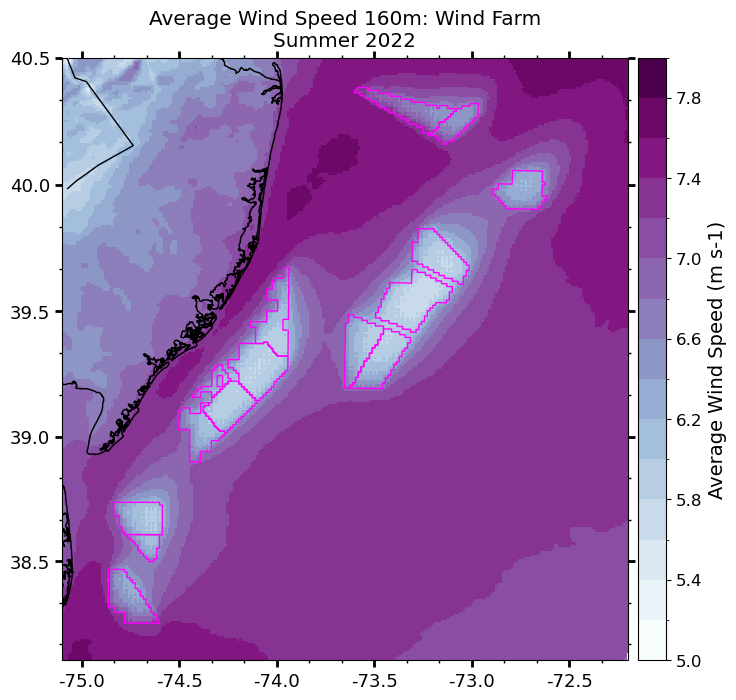

In [141]:
kwargs = dict()  # keyword arguments for generating the map
kwargs['figsize'] = (8, 8)
kwargs['oceancolor'] = 'none'
kwargs['landcolor'] = 'none'
kwargs['coast'] = 'full'
kwargs['decimal_degrees'] = True
fig, ax = cplt.create(extent, **kwargs)  # generate the map using cool_maps

pargs = dict()  # keyword arguments for plotting the model output
pargs['norm_clevs'] = norm
pargs['extend'] = 'neither'
pargs['cmap'] = cmap
pargs['clab'] = color_label
plot_pcolormesh(fig, ax, vsub.XLONG, vsub.XLAT, vsub.values, **pargs)  # plot the model output

if h:  # if a height is specified, add it to the title and save file name
    title = f'{vsub.long_name} {h}m: Wind Farm\nSummer 2022'
    save_file = f'{variable}_{h}m_avg-1km_wf2km_nyb-surfacemap.png'
else:  # if no height is specified, define the title and save file name without height
    title = f'{vsub.long_name}: Wind Farm\nSummer 2022'
    save_file = f'{variable}_avg-1km_wf2km_nyb-surfacemap.png'
ax.set_title(title, pad=8)

# shapefiles downloaded from the BOEM website: https://www.boem.gov/renewable-energy/mapping-and-data/renewable-energy-gis-data
lease = f'{os.getcwd()}/BOEM_Renewable_Energy_Shapefiles_2_2023/Wind_Lease_Outlines_2_2023.shp'
oargs = dict()
oargs['edgecolor'] = 'magenta'
map_add_boem_outlines(ax, lease, **oargs)  # add the BOEM lease outlines to the map in magenta

save_filepath = os.path.join(save_dir, save_file)
print(save_filepath)  # print the filepath so you know where the file is being saved
plt.savefig(save_filepath, dpi=300)


Now let's do the same thing, but add the model output from the control version of the model and change the title and save_file.

/Users/garzio/Documents/rucool/rmi-ocean-mixing/plots/ws_160m_avg-1km_ctrl-surfacemap.png


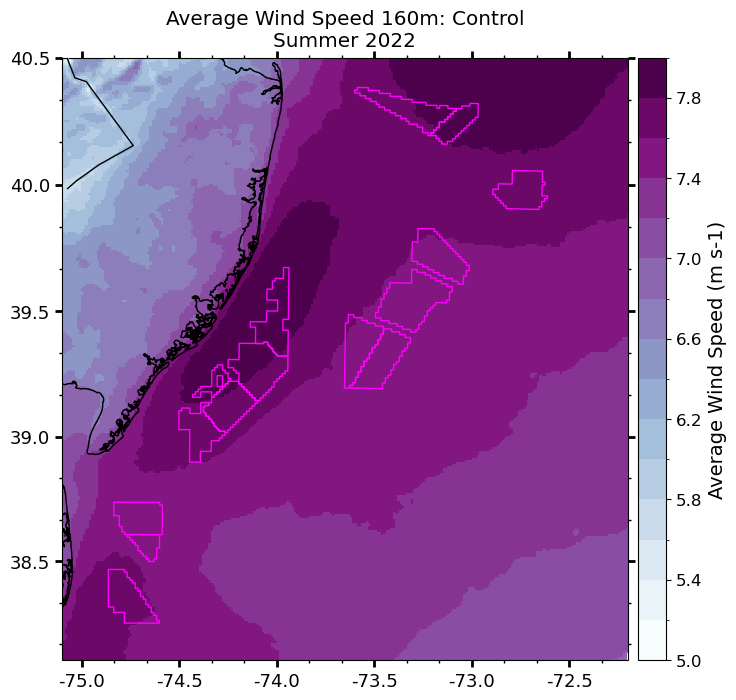

In [142]:
kwargs = dict()  # keyword arguments for generating the map
kwargs['figsize'] = (8, 8)
kwargs['oceancolor'] = 'none'
kwargs['landcolor'] = 'none'
kwargs['coast'] = 'full'
kwargs['decimal_degrees'] = True
fig, ax = cplt.create(extent, **kwargs)  # generate the map using cool_maps

pargs = dict()  # keyword arguments for plotting the model output
pargs['norm_clevs'] = norm
pargs['extend'] = 'neither'
pargs['cmap'] = cmap
pargs['clab'] = color_label
plot_pcolormesh(fig, ax, vctrlsub.XLONG, vctrlsub.XLAT, vctrlsub.values, **pargs)  # plot the model output

if h:  # if a height is specified, add it to the title and save file name
    title = f'{vctrlsub.long_name} {h}m: Control\nSummer 2022'
    save_file = f'{variable}_{h}m_avg-1km_ctrl-surfacemap.png'
else:  # if no height is specified, define the title and save file name without height
    title = f'{vctrlsub.long_name}: Control\nSummer 2022'
    save_file = f'{variable}_avg-1km_ctrl-surfacemap.png'
ax.set_title(title, pad=8)

# shapefiles downloaded from the BOEM website: https://www.boem.gov/renewable-energy/mapping-and-data/renewable-energy-gis-data
lease = f'{os.getcwd()}/BOEM_Renewable_Energy_Shapefiles_2_2023/Wind_Lease_Outlines_2_2023.shp'
oargs = dict()
oargs['edgecolor'] = 'magenta'
map_add_boem_outlines(ax, lease, **oargs)  # add the BOEM lease outlines to the map in magenta

save_filepath = os.path.join(save_dir, save_file)
print(save_filepath)  # print the filepath so you know where the file is being saved
plt.savefig(save_filepath, dpi=300)

Those two versions of the model look strikingly different, so let's make the same map with the differences between the two. For these plots we want to add contour lines to be able to clearly define the values of some of the differences. So let's write a function to add contour lines to a plot.

In [143]:
def add_contours(ax, londata, latdata, vardata, clist, label_format=None, color='black', linewidth=.5, linestyle='-'):
    """
    Adds black contour lines with labels to a cartopy map object
    :param ax: plotting axis object
    :param londata: longitude data
    :param latdata: latitude data
    :param vardata: variable data
    :param clist: list of contour levels
    :param label_format: optional format for contour labels (e.g. '%.1f')
    """
    label_format = label_format or '%d'

    CS = ax.contour(londata, latdata, vardata, clist, colors=color, linewidths=linewidth,
                    linestyle=linestyle, transform=ccrs.PlateCarree())
    ax.clabel(CS, inline=True, fontsize=10.5, fmt=label_format)

Now we will make the surface maps of the differences. The values of the contour lines will change with each variable, which is why there are a few if/else statements in the block of code below. You could do it this way, or those values could be added into the configurations defined in the beginning of the tutorial.

In [144]:
# get the colorbar limits from the configurations, or calculate them based on the data
try:
    cmin = vconfigs['difflims'][0]
    cmax = vconfigs['difflims'][1]
    bins = vconfigs['diffbins']
except KeyError:
    cmax = np.ceil(np.nanmax(abs(diff)))
    cmin = -cmax
    bins = (cmax - cmin) * 10
print(f'{variable} difference colorbar range: [{cmin}, {cmax}]')

ws difference colorbar range: [-2, 2]


In [145]:
# get the the color map from the configurations, or use the default RdBu_r colormap
try:
    cmap = vconfigs['diffcmap']
except KeyError:
    cmap = plt.get_cmap('RdBu_r')

levels = MaxNLocator(nbins=bins).tick_values(cmin, cmax)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
color_label = f'{diff.long_name} ({diff.units})'
print(color_label)

Average Wind Speed Difference (m s-1)


/Users/garzio/Documents/rucool/rmi-ocean-mixing/plots/ws_160m_avg-diff-surfacemap.png


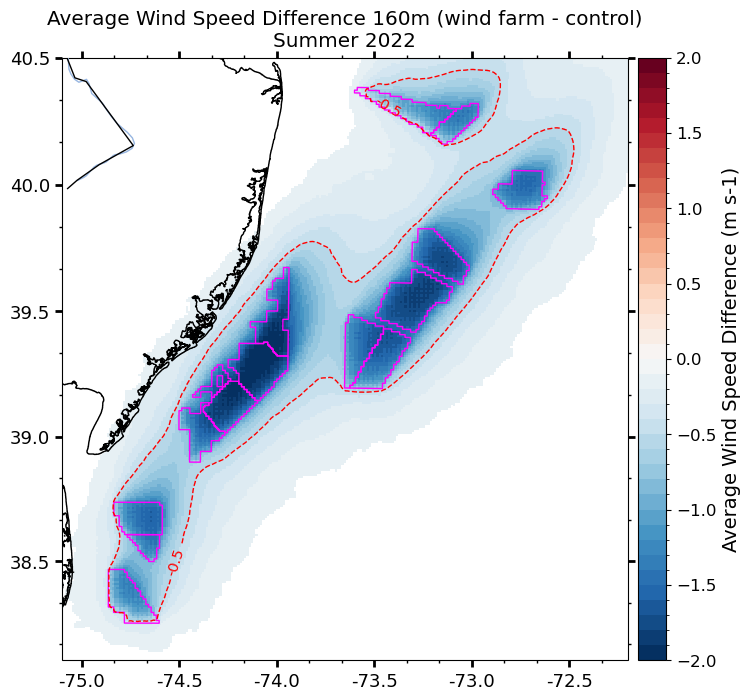

In [146]:
kwargs = dict() # keyword arguments for generating the map
kwargs['figsize'] = (8, 8)
kwargs['oceancolor'] = 'none'
kwargs['landcolor'] = 'none'
kwargs['coast'] = 'full'
kwargs['decimal_degrees'] = True
fig, ax = cplt.create(extent, **kwargs)

# add contour lines to the map for some variables
if variable in ['ws', 'ws10']:
    contour_list = [-0.5]
    add_contours(ax, diff.XLONG, diff.XLAT, masked_diff, contour_list, label_format='%.1f', color='red', linewidth=1, linestyle='--')
if variable in ['UST']:
    contour_list = [-0.02]
    add_contours(ax, diff.XLONG, diff.XLAT, masked_diff, contour_list, label_format='%.2f', color='red', linewidth=1, linestyle='--')
    contour_list = [-0.024]
    add_contours(ax, diff.XLONG, diff.XLAT, masked_diff, contour_list, label_format='%.2f', color='blue', linewidth=1,
                    linestyle='--')
if variable in ['TEMP']:
    contour_list = [-.1, .1]
    add_contours(ax, diff.XLONG, diff.XLAT, masked_diff, contour_list, label_format='%.1f', color='blue', linewidth=1,
                    linestyle='--')
if variable in ['T2', 'TSK']:
    contour_list = [-.05, .05]
    add_contours(ax, diff.XLONG, diff.XLAT, masked_diff, contour_list, label_format='%.2f', color='blue', linewidth=1,
                    linestyle='--')
if variable in ['HFX']:
    contour_list = [.5]
    add_contours(ax, diff.XLONG, diff.XLAT, masked_diff, contour_list, label_format='%.2f', color='blue', linewidth=1,
                    linestyle='--')
if variable in ['Q2']:  # adjust the margins a little bit for Q2
    plt.subplots_adjust(right=.9, left=0.05)

pargs = dict() # keyword arguments for plotting the model output
pargs['norm_clevs'] = norm
pargs['extend'] = 'neither'
pargs['cmap'] = cmap
pargs['clab'] = color_label

plot_pcolormesh(fig, ax, diff.XLONG, diff.XLAT, masked_diff, **pargs)  # plot differences

# shapefiles downloaded from the BOEM website: https://www.boem.gov/renewable-energy/mapping-and-data/renewable-energy-gis-data
lease = f'{os.getcwd()}/BOEM_Renewable_Energy_Shapefiles_2_2023/Wind_Lease_Outlines_2_2023.shp'
oargs = dict()
oargs['edgecolor'] = 'magenta'
map_add_boem_outlines(ax, lease, **oargs)  # add the BOEM lease outlines to the map in magenta

if h:  # if a height is specified, add it to the title and save file name
    title = f'{diff.long_name} {h}m (wind farm - control)\nSummer 2022'
    save_file = f'{variable}_{h}m_avg-diff-surfacemap.png'
else:  # if no height is specified, define the title and save file name without height
    title = f'{diff.long_name} (wind farm - control)\nSummer 2022'
    save_file = f'{variable}_avg-diff-surfacemap.png'

ax.set_title(title, pad=8)  # adjust the title position

save_filepath = os.path.join(save_dir, save_file)
print(save_filepath)  # print the filepath so you know where the file is being saved
plt.savefig(save_filepath, dpi=300)

Here is our average wind speed difference plot with a dashed red contour line at -0.5 m/s. All of these images should also be saved on your local machine where you specified save_dir. Now you can go back through this tutorial to generate plots of the other variables that are listed in the beginning.